In [1]:
!pwd
!ls


/content
sample_data


In [2]:
!rm -rf Adversarial_Examples_Results_Reproduction

In [3]:
# clone repository
!git clone https://github.com/Shounak-Ghosh/Adversarial_Examples_Results_Reproduction.git

Cloning into 'Adversarial_Examples_Results_Reproduction'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 17300 (delta 43), reused 19 (delta 9), pack-reused 17221
Receiving objects: 100% (17300/17300), 107.42 MiB | 24.47 MiB/s, done.
Resolving deltas: 100% (89/89), done.
Checking out files: 100% (17093/17093), done.


In [4]:
!pwd
!pip install virtualenv
!virtualenv -p python3.6 env
!source ecg_env/bin/activate
!python -V

/content
     |████████████████████████████████| 4.9MB 3.5MB/s 
     |████████████████████████████████| 337kB 51.7MB/s 
created virtual environment CPython3.6.9.final.0-64 in 767ms
  creator CPython3Posix(dest=/content/env, clear=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==20.2.2, setuptools==49.6.0, wheel==0.35.1
  activators BashActivator,CShellActivator,FishActivator,PowerShellActivator,PythonActivator,XonshActivator
/bin/bash: ecg_env/bin/activate: No such file or directory
Python 3.6.9


In [5]:
!pip install tensorflow==1.8.0
!pip install cleverhans==2.1.0
!pip install keras==2.2.0
!pip install tensorflow
# !pip install --upgrade keras

     |████████████████████████████████| 49.1MB 69kB/s 
     |████████████████████████████████| 3.1MB 17.0MB/s 
     |████████████████████████████████| 890kB 52.9MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107220 sha256=c25c1a77b7b881a506b3374c2847692c3936b3f73b0672d5a5738745b8f2adca
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.1.5
    Uninstalling bleach-3.1.5:
      Successfully uninstalled bleach-3.1.5
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
     |███████████████████████

In [47]:
%cd Adversarial_Examples_Results_Reproduction

[Errno 2] No such file or directory: 'Adversarial_Examples_Results_Reproduction'
/content/Adversarial_Examples_Results_Reproduction


In [48]:
!python cloud_eval_diff.py data_select_A.csv 3 4


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:522: FutureWarn

In [53]:
%cd .. 

/content/Adversarial_Examples_Results_Reproduction


In [54]:

%cd Adversarial_Examples_Results_Reproduction
%cd cloud_model

[Errno 2] No such file or directory: 'Adversarial_Examples_Results_Reproduction'
/content/Adversarial_Examples_Results_Reproduction
/content/Adversarial_Examples_Results_Reproduction/cloud_model


In [55]:
from keras.utils import plot_model
import keras.backend as K
import keras
from keras import backend
from keras.models import load_model
from keras.utils.np_utils import to_categorical
from keras import metrics
import tensorflow as tf

In [52]:
import h5py
from numpy import genfromtxt
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, filtfilt
import scipy.fftpack
import matplotlib.pyplot as plt
import matplotlib.figure as figure
import os
import glob
import csv
import sys

In [56]:
dataDir = "../training2017/"
folder1 = "./smooth_eval/"
folder2 = "./l2_eval/"
folder3 = "./l2smooth_0_01_eval/"
FS = 300
WINDOW_SIZE = 30*FS     # padding window for CNN
classes = ['A', 'N', 'O','~']


In [57]:
#### Funtion definition
def preprocess(x, maxlen):
    x =  np.nan_to_num(x)
#    x =  x[0, 0:min(maxlen,len(x))]
    x =  x[0, 0:maxlen]
    x = x - np.mean(x)
    x = x / np.std(x)

    tmp = np.zeros((1, maxlen))
    tmp[0, :len(x)] = x.T  # padding sequence
    x = tmp
    x = np.expand_dims(x, axis=2)  # required by Keras
    del tmp

    return x

In [58]:
print("Enter index of signal for which perturbations are generated, in the mat file")
idx = int(input())
print("Enter Ground truth index [A,N,O,~]=[0,1,2,3] for this signal:")
TRUTH = int(input())
g_label = classes[int(TRUTH)]
print("Enter the target class for which you want misclassification to occur [A,N,O,~]=[0,1,2,3]")
TARGET = int(input())
t_label = classes[int(TARGET)]

Enter index of signal for which perturbations are generated, in the mat file
71
Enter Ground truth index [A,N,O,~]=[0,1,2,3] for this signal:
0
Enter the target class for which you want misclassification to occur [A,N,O,~]=[0,1,2,3]
1


In [59]:
!pwd

/content/Adversarial_Examples_Results_Reproduction/cloud_model


In [60]:
record = "A{:05d}".format(idx)
local_filename = dataDir+record
print('Loading record {}'.format(record))
mat_data = scipy.io.loadmat(local_filename)
data = mat_data['val']
data = preprocess(data, WINDOW_SIZE)
sample = np.reshape(data, (9000,1))

print(mat_data.items())
print(data.shape)

Loading record A00071
dict_items([('val', array([[  17,   19,   21, ..., -116,  -83,  -52]], dtype=int16))])
(1, 9000, 1)


In [61]:
file1 = glob.glob(folder1 + "R" +  str(idx) + "_" + str(TRUTH) + "_" + str(TARGET) + "_?.csv")[0]
adv_sample_1 = genfromtxt(file1, delimiter=',')
adv_sample_1 = np.reshape(adv_sample_1, (9000,1))
res_1 = file1[-5]
r_label_1 = classes[int(res_1)]
print("The file has been loaded from",folder1)

The file has been loaded from ./smooth_eval/


In [ ]:
# file2 = glob.glob(folder2 + "R" +  str(idx) + "_" + str(TRUTH) + "_" + str(TARGET) + "_?.csv")[0]
# adv_sample_2 = genfromtxt(file2, delimiter=',')
# adv_sample_2 = np.reshape(adv_sample_2, (9000,1))
# res_2 = file2[-5]
# r_label_2 = classes[int(res_2)]
# print("The file has been loaded from",folder2)

In [ ]:
# file3 = glob.glob(folder3 + "R" +  str(idx) + "_" + str(TRUTH) + "_" + str(TARGET) + "_?.csv")[0]
# adv_sample_3 = genfromtxt(file3, delimiter=',')
# adv_sample_3 = np.reshape(adv_sample_3, (9000,1))
# res_3 = file3[-5]
# r_label_3 = classes[int(res_3)]
# print("The file has been loaded from",folder3)

(9000, 1)
(9000, 1)
(9000, 1)


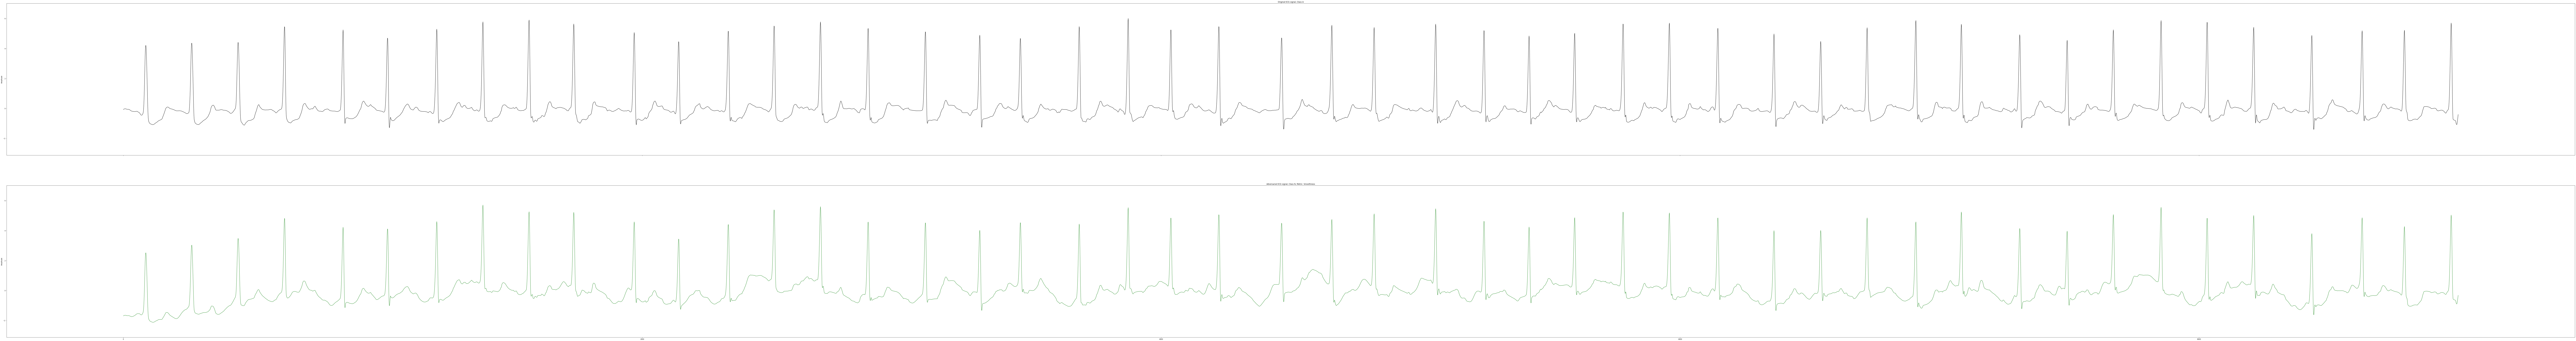

In [62]:
#Original Plot

#taken out (, adv_sample_2, adv_sample_3) from the lists below
ymax = np.max([sample, adv_sample_1])+1
ymin = np.min([sample, adv_sample_1])-1
len = 20000

# first param changed from 4
fig, axs = plt.subplots(2, 1, figsize=(300,40), sharex=True)

axs[0].plot(sample[0:len,:], color='black', label='Original signal')
axs[0].set_title('Original ECG signal, Class {}'.format(g_label))
axs[0].set_ylim([ymin, ymax])
axs[0].set_ylabel('Amplitude')

print(adv_sample_1.shape)

axs[1].plot(adv_sample_1[0:len,:], color='forestgreen', label='Adv signal_diff')
axs[1].set_title('Adversarial ECG signal, Class {}, Metric: Smoothness'.format(r_label_1))
axs[1].set_ylim([ymin, ymax])
axs[1].set_ylabel('Amplitude')

# axs[2].plot(adv_sample_2[0:4000,:], color='forestgreen', label='Adv signal_l2')
# axs[2].set_title('Adversarial ECG signal, Class {}, Metric: L2-norm'.format(r_label_1))
# axs[2].set_ylim([ymin, ymax])
# axs[2].set_ylabel('Amplitude')

# axs[3].plot(adv_sample_3[0:4000,:], color='forestgreen', label='Adv signal_l2_diff')
# axs[3].set_title('Adversarial ECG signal, Class {}, Metric: Smoothness+L2-norm'.format(r_label_1))
# axs[3].set_ylim([ymin, ymax])
# axs[3].set_xlabel('Sample Index')
# axs[3].set_ylabel('Amplitude')
# fig.tight_layout()
# fig.show()
# plt.show()
print(sample.shape)
print(adv_sample_1.shape)

Hence, each data point was targeted to 3 other classes (different from the ground truth) with 3 different metrics
So, 9 files are generated for 1 signal

The ground truth of the file loaded here is class A (index 0), the record file is A00005
The adversarial examples are generated as follows: 
For L2 metric: (inside folder l2_eval)
> 
    file R5_0_1_1.csv = AE targeted for class index 1 (Normal Rhythm)
    file R5_0_2_2.csv = AE targeted for class index 2 (Other Rhythm)
    file R5_0_3_3.csv = AE targeted for class index 3 (Noise)

    
For Dsmooth metric: (inside folder smooth_eval)
>
    file R5_0_1_1.csv = AE targeted for class index 1 (Normal Rhythm)
    file R5_0_2_2.csv = AE targeted for class index 2 (Other Rhythm)
    file R5_0_3_3.csv = AE targeted for class index 3 (Noise)

For DsmoothL2 metric: (inside folder l2smooth_0_01_eval)
>
    file R5_0_1_1.csv = AE targeted for class index 1 (Normal Rhythm)
    file R5_0_2_2.csv = AE targeted for class index 2 (Other Rhythm)
    file R5_0_3_3.csv = AE targeted for class index 3 (Noise)
    
Lets load the model and verify that they are indeed misclassified.


In [63]:
from keras.models import load_model

In [64]:
#pre-processing required before applying model 

def preprocess(x, maxlen):
    
    #Replace any 'not a number with a zero and infinity'
    x =  np.nan_to_num(x)
    
    # The value of maxlen is set to 9000 before passing to the function
    # Clip the data at 9000 points, new size of data is 1x9000 if the size of x > 9000
    # But this is adaptive, if the length of x is less than 9000, it retains original size
    # This also converts x from a 2d array to 1d
    
    x =  x[0, 0:maxlen]
    #x =  x[0:maxlen]
    
    # Standard Scaling (mean and std of this particular data for each)
    x = x - np.mean(x)
    x = x / np.std(x)

    # init a 2D array of size 1x9000
    tmp = np.zeros((1, maxlen))
    
    # copy the contents of x to tmp
    # but tmp here is 2D array
    # what is the meaning of padding sequence?
    tmp[0, :len(x)] = x.T  # padding sequence
    
    # convert x back to 2D array with scaled contents
    x = tmp
    
    # This is the most strange step, they say it is required by keras
    # They convert the scaled x values to a 3D array (axis =2)
    # With values written as [[[0.7],[0.6],[0.4],....]]
    x = np.expand_dims(x, axis=2)  # required by Keras
    
    #delete temp
    del tmp
    
    return x

def predict_data(model,x):
    
    # The model expects a numpy array as a input (Keras)
    # The output that the predict function returns is a list of probabilities of all 4 classes
    prob = model.predict(x)
    
    # Returns an index of the max value in an array
    ann = np.argmax(prob)
    
    return prob,ann

In [65]:
print("Loading model")    
model = load_model("../ResNet_30s_34lay_16conv.hdf5")

Loading model


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [36]:

# Lets load the 9 files
# Since R5 did not work for L2, I used R9 But that did not work as well

# f1 = glob.glob(folder2 + "R" +  "5" + "_" + "0" + "_" + "1" + "_?.csv")[0]
# l2_normal = genfromtxt(f1, delimiter=',')
# l2_normal = np.reshape(l2_normal, (1,9000))

# f2 = glob.glob(folder2 + "R" +  "5" + "_" + "0" + "_" + "2" + "_?.csv")[0]
# l2_other = genfromtxt(f2, delimiter=',')
# l2_other = np.reshape(l2_other, (1,9000))

# f3 = glob.glob(folder2 + "R" +  "5" + "_" + "0" + "_" + "3" + "_?.csv")[0]
# l2_noise = genfromtxt(f3, delimiter=',')
# l2_noise = np.reshape(l2_noise, (1,9000))

f4 = glob.glob(folder1 + "R" +  str(idx) + "_" + "0" + "_" + "1" + "_1.csv")[0]
smooth_normal = genfromtxt(f4, delimiter=',')
smooth_normal = np.reshape(smooth_normal, (1,9000))

f5 = glob.glob(folder1 + "R" +  str(idx) + "_" + "0" + "_" + "2" + "_2.csv")[0]
smooth_other = genfromtxt(f5, delimiter=',')
smooth_other = np.reshape(smooth_other, (1,9000))

f6 = glob.glob(folder1 + "R" +  str(idx) + "_" + "0" + "_" + "3" + "_3.csv")[0]
smooth_noise = genfromtxt(f6, delimiter=',')
smooth_noise = np.reshape(smooth_noise, (1,9000))

# f7 = glob.glob(folder3 + "R" +  "5" + "_" + "0" + "_" + "1" + "_?.csv")[0]
# smooth_l2_normal = genfromtxt(f7, delimiter=',')
# smooth_l2_normal = np.reshape(smooth_l2_normal, (1,9000))

# f8 = glob.glob(folder3 + "R" +  "5" + "_" + "0" + "_" + "2" + "_?.csv")[0]
# smooth_l2_other = genfromtxt(f8, delimiter=',')
# smooth_l2_other = np.reshape(smooth_l2_other, (1,9000))

# f9 = glob.glob(folder3 + "R" +  "5" + "_" + "0" + "_" + "3" + "_?.csv")[0]
# smooth_l2_noise = genfromtxt(f9, delimiter=',')
# smooth_l2_noise = np.reshape(smooth_l2_noise, (1,9000))

In [66]:
# l2_normal_new = preprocess(l2_normal, 9000)
# l2_other_new = preprocess(l2_other, 9000)
# l2_noise_new = preprocess(l2_noise, 9000)

smooth_normal_new = preprocess(smooth_normal, 9000)
smooth_other_new = preprocess(smooth_other, 9000)
smooth_noise_new = preprocess(smooth_noise, 9000)

# smooth_l2_normal_new = preprocess(smooth_l2_normal, 9000)
# smooth_l2_other_new = preprocess(smooth_l2_other, 9000)
# smooth_l2_noise_new = preprocess(smooth_l2_noise, 9000)

TypeError: ignored

In [ ]:
classes = ['A', 'N', 'O','~']
# prob_1,a1 = predict_data(model,l2_normal_new)
# prob_2,a2 = predict_data(model,l2_other_new)
# prob_3,a3 = predict_data(model,l2_noise_new)

prob_4,a4 = predict_data(model,smooth_normal_new)
prob_5,a5 = predict_data(model,smooth_other_new)
prob_6,a6 = predict_data(model,smooth_noise_new)

# prob_7,a7 = predict_data(model,smooth_l2_normal_new)
# prob_8,a8 = predict_data(model,smooth_l2_other_new)
# prob_9,a9 = predict_data(model,smooth_l2_noise_new)

In [ ]:
sample_new = preprocess(sample,9000)
prob_original,original = predict_data(model,sample_new)
print("Original Sample")
print("probability:", prob_original,"Class:", classes[original])

In [ ]:
# print(classes[a1])
# print(classes[a2])
# print(classes[a3])

print("Adversarial Attacks")
# print("probability:", prob_4[0],"Class:", classes[a4])
print("probability:", prob_5[0][a5],"Class:",classes[a5])
# print("probability:", prob_6[0][a6],"Class:",classes[a6])

# print(classes[a7])
# print(classes[a8])
# print(classes[a9])

Hence, we verified the Adversarial Examples for 6 records (except L2).
As we can see, not all of them are working as expected.

In [ ]:
def plot_ECG(data):
    x_axis = np.linspace(0.,9000.,num=9000)
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(16,5))
    plt.plot(x_axis, data,'r')
    plt.axis([0, 9000,-10, 10])
    #plt.title(class_name)
    plt.ylabel('milli Volts')
    plt.xlabel('Time (in seconds)')
    plt.tight_layout()
    plt.show()

In [ ]:
plot_ECG(smooth_l2_normal[0])
plot_ECG(smooth_l2_other[0])
plot_ECG(smooth_l2_noise[0])

In [ ]:
%cd ../